In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.data import Dataset
import keras_tuner
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 100)


2022-11-06 20:36:27.278525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
season_dfs = list()
seasons = np.arange(2020, 2023)
for season in seasons:
    season_dfs.append(pd.read_csv(f"data/{season}.csv"))
df = pd.concat(season_dfs).reset_index(drop=True)
    

In [3]:
dummy_df = pd.get_dummies(df[['count', 'pitch_type_lag_1', 'pitch_type_lag_2']], prefix=['count', 'lag_1', 'lag_2'])
df = df.join(dummy_df)
df.head()


,game_id,inning,top,at_bat_index,home_score,away_score,outs,pitcher_name,pitcher_id,pitcher_lefty,batter_name,batter_id,batter_lefty,runner_1,runner_2,runner_3,balls,strikes,pitch_type,at_bat,raw_pitch_type,count,pitch_type_lag_1,pitch_type_lag_2,lag_1_ball,lag_1_strike,lag_2_ball,lag_2_strike,lag_3_ball,lag_3_strike,pitch_count,inning_pitch_count,ab_pitch_count,ab_changeup_count,ab_curveball_count,ab_cutter_count,ab_fastball_count,ab_knuckle_curve_count,ab_other_count,ab_sinker_count,ab_slider_count,ab_splitter_count,nth_season_pitch,fastball_rate,sinker_rate,slider_rate,changeup_rate,knuckle_curve_rate,curveball_rate,cutter_rate,splitter_rate,other_rate,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter
0,630852,1,True,0,0,0,0,Tanner Roark,543699,False,Hanser Alberto,593643,False,False,False,False,0,0,fastball,0,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,630852,1,True,1,0,0,1,Tanner Roark,543699,False,Anthony Santander,623993,True,False,False,False,0,0,fastball,1,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,1,1,0,0,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,630852,1,True,1,0,0,1,Tanner Roark,543699,False,Anthony Santander,623993,True,False,False,False,0,1,fastball,1,Four-Seam Fastball,"(0,1)",fastball,none,False,True,False,False,False,False,2,2,1,0,0,0,1,0,0,0,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,630852,1,True,1,0,0,1,Tanner Roark,543699,False,Anthony Santander,623993,True,False,False,False,0,2,fastball,1,Four-Seam Fastball,"(0,2)",fastball,fastball,False,True,False,True,False,False,3,3,2,0,0,0,2,0,0,0,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,630852,1,True,2,0,0,2,Tanner Roark,543699,False,Jose Iglesias,578428,False,False,False,False,0,0,sinker,2,Sinker,"(0,0)",none,none,False,False,False,False,False,False,4,4,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [4]:
pitch_types = list(df.pitch_type.unique())
direct_features = ['inning', 'top', 'outs', 'pitch_count', 'inning_pitch_count', 'ab_pitch_count', 'pitcher_lefty', 'batter_lefty']
direct_features.extend(['lag_1_ball', 'lag_1_strike'])
direct_features.extend(['runner_1', 'runner_2', 'runner_3'])
direct_features.extend([f"ab_{pitch_type}_count" for pitch_type in pitch_types])
features = direct_features + list(dummy_df.columns) + [c for c in df.columns if c.endswith("_rate")]
X = df.loc[df['raw_pitch_type'] != "other"].dropna(subset=features)[features]
y = df.loc[df['raw_pitch_type'] != "other"].dropna(subset=features)['pitch_type']
y = pd.get_dummies(y)
X.head()


,inning,top,outs,pitch_count,inning_pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,lag_1_ball,lag_1_strike,runner_1,runner_2,runner_3,ab_fastball_count,ab_sinker_count,ab_slider_count,ab_changeup_count,ab_knuckle_curve_count,ab_curveball_count,ab_cutter_count,ab_splitter_count,ab_other_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,sinker_rate,slider_rate,changeup_rate,knuckle_curve_rate,curveball_rate,cutter_rate,splitter_rate,other_rate
489,7,False,0,99,0,0,False,True,False,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.330000,0.170000,0.0,0.320000,0.180000,0.0,0.0,0.0,0.0
490,7,False,0,100,1,1,False,True,True,False,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.326733,0.168317,0.0,0.316832,0.188119,0.0,0.0,0.0,0.0
491,7,False,0,101,2,2,False,True,False,True,False,False,False,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.323529,0.166667,0.0,0.313725,0.196078,0.0,0.0,0.0,0.0
492,7,False,1,102,3,0,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.330097,0.165049,0.0,0.310680,0.194175,0.0,0.0,0.0,0.0
493,7,False,1,103,4,1,False,False,False,True,False,False,False,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.326923,0.163462,0.0,0.317308,0.192308,0.0,0.0,0.0,0.0


In [5]:
ss = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)
X_train_numpy = X_train.astype(float).to_numpy()
y_train_numpy = y_train.astype(float).to_numpy()
X_val_numpy = X_val.astype(float).to_numpy()
y_val_numpy = y_val.astype(float).to_numpy()
X_train_numpy = ss.fit_transform(X_train_numpy)
X_val_numpy = ss.transform(X_val_numpy)
input_shape = X.shape[1]
output_shape = y.shape[1]


____

#### Tuner

In [8]:
class CustomHyperModel(keras_tuner.HyperModel):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        
    def build(self, hp):
        # Input layer
        model = keras.Sequential(name='sequential_nn')
        model.add(keras.Input(shape=(self.input_shape,), name='input'))
        
        # First hidden layer
        l1_nodes = hp.Int("l1_nodes", min_value=64, max_value=80, step=16)
        l1_dropout = hp.Float("l1_dropout", min_value=0.0, max_value=0.1, step=0.05)
        model.add(layers.Dense(l1_nodes, name='dense_1'))
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(l1_dropout))
        
        # Second hidden layer
        l2_nodes = hp.Int("l2_nodes", min_value=64, max_value=80, step=16)        
        l2_dropout = hp.Float("l2_dropout", min_value=0.1, max_value=0.1, step=0.05)
        model.add(layers.Dense(l2_nodes, name='dense_2'))
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(l2_dropout))
        
        # Output layer
        model.add(layers.Dense(output_shape, name="output"))
        model.add(layers.Activation("softmax"))
        model.summary()
        
        # Compile
        lr = hp.Float("lr", min_value=5e-4, max_value=1e-3, step=2.5e-4)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy')
        return model


In [9]:
tuner = keras_tuner.RandomSearch(
    hypermodel=CustomHyperModel(input_shape, output_shape),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    project_name='keras_tuner',
    overwrite=True,
)
tuner.search(X_train_numpy, y_train_numpy, validation_data=(X_val_numpy, y_val_numpy))


Trial 12 Complete [00h 00m 28s]
val_loss: 1.1426655054092407

Best val_loss So Far: 1.1358388662338257
Total elapsed time: 00h 05m 56s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
best_hyperparameters

{'l1_nodes': 80,
 'l1_dropout': 0.05,
 'l2_nodes': 64,
 'l2_dropout': 0.05,
 'lr': 0.00075}

In [12]:
model = tuner.get_best_models()[0]
model.summary()


Model: "sequential_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 80)                5120      
                                                                 
 activation (Activation)     (None, 80)                0         
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                5184      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 output (Dense)              (None, 9)               

In [13]:
# Get fitted values
y_hat = model.predict(X_val_numpy, verbose=0)
y_hat = pd.DataFrame(y_hat, index=y_val.index, columns=y_val.columns)
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, y_hat).numpy()


1.1358389

In [14]:
# Get mean rate by pitch type
X_eval = X_val.copy(deep=True)
X_eval['pitch_type'] = y_val.idxmax(axis=1)
pitch_rates = [c for c in X_eval.columns if c.endswith("_rate")]
mean_rate_by_type = X_eval.groupby('pitch_type')[pitch_rates].mean()
mean_rate_by_type.sort_index(key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
mean_rate_by_type = mean_rate_by_type[[c + "_rate" for c in list(y_train.sum().sort_values(ascending=False).index)]].copy(deep=True) 
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, X_eval[[c + "_rate" for c in y_val.columns]]).numpy()


1.223284311346132

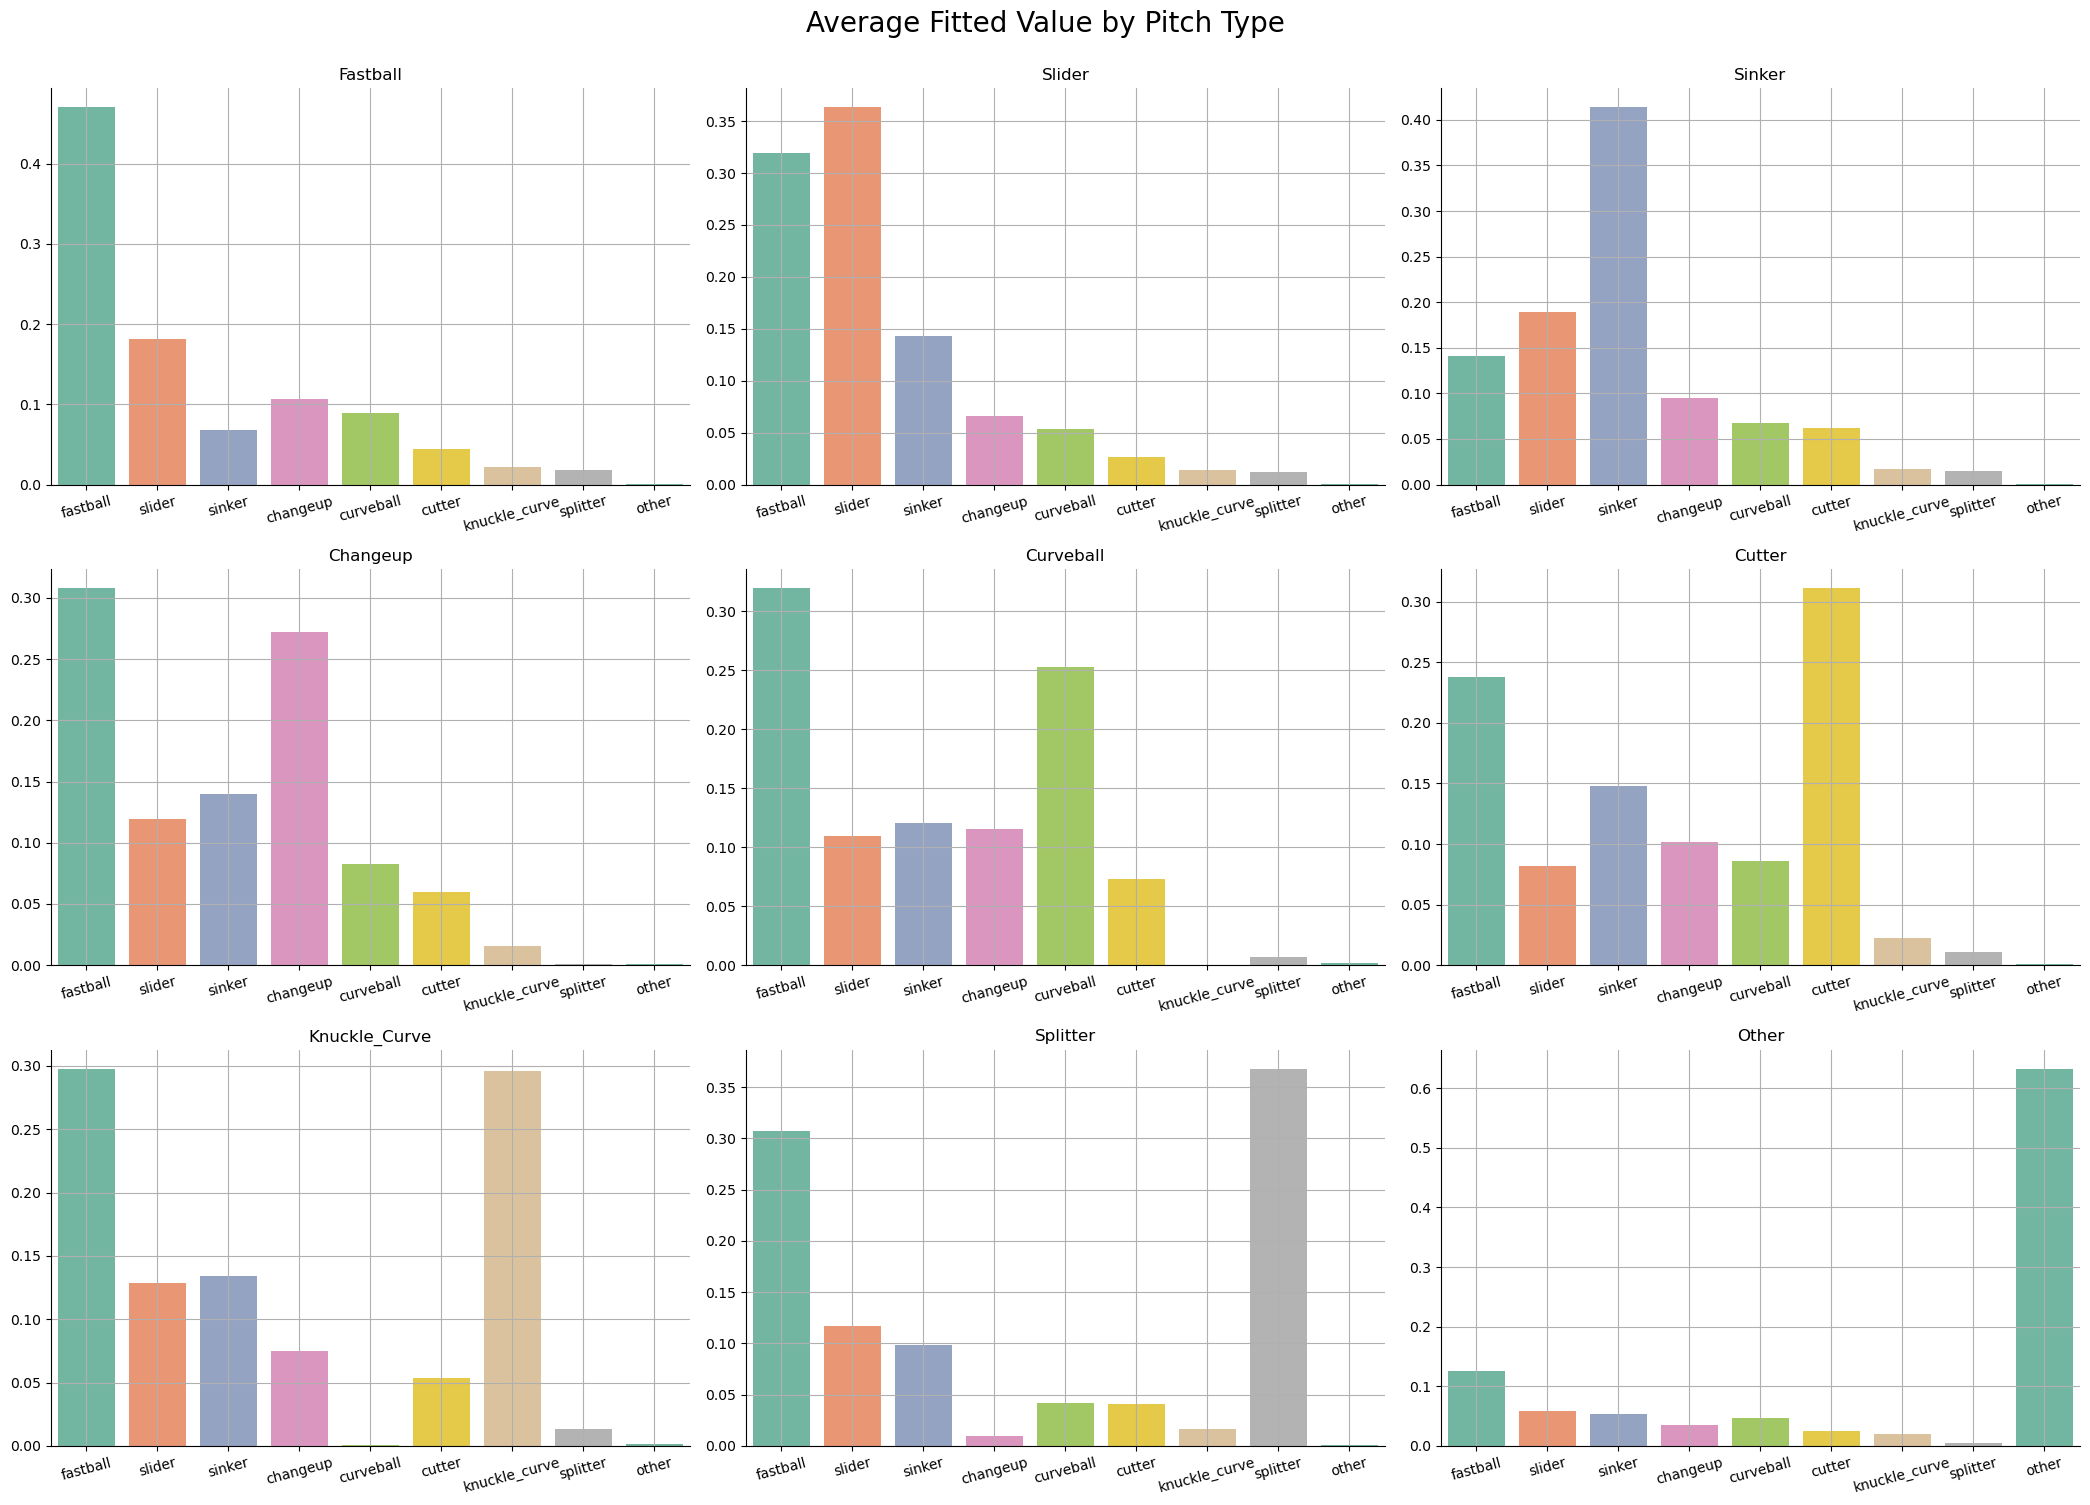

In [23]:
y_eval = y_hat.copy(deep=True)
y_eval['observed'] = y_val.idxmax(axis=1)
g = y_eval.groupby('observed').mean().reset_index()
g.sort_values('observed', key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
g = g[['observed'] + list(y_train.sum().sort_values(ascending=False).index)].copy(deep=True) # reorder columns
g.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    probabilities = g.iloc[i]
    observed = probabilities.pop('observed')
    sns.barplot(x=probabilities.index, y=probabilities.values, ax=ax, palette='Set2')
    ax.set(title=observed.title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.grid()

fig.suptitle("Average Fitted Value by Pitch Type", fontsize=20, y=1)
plt.tight_layout()
sns.despine()



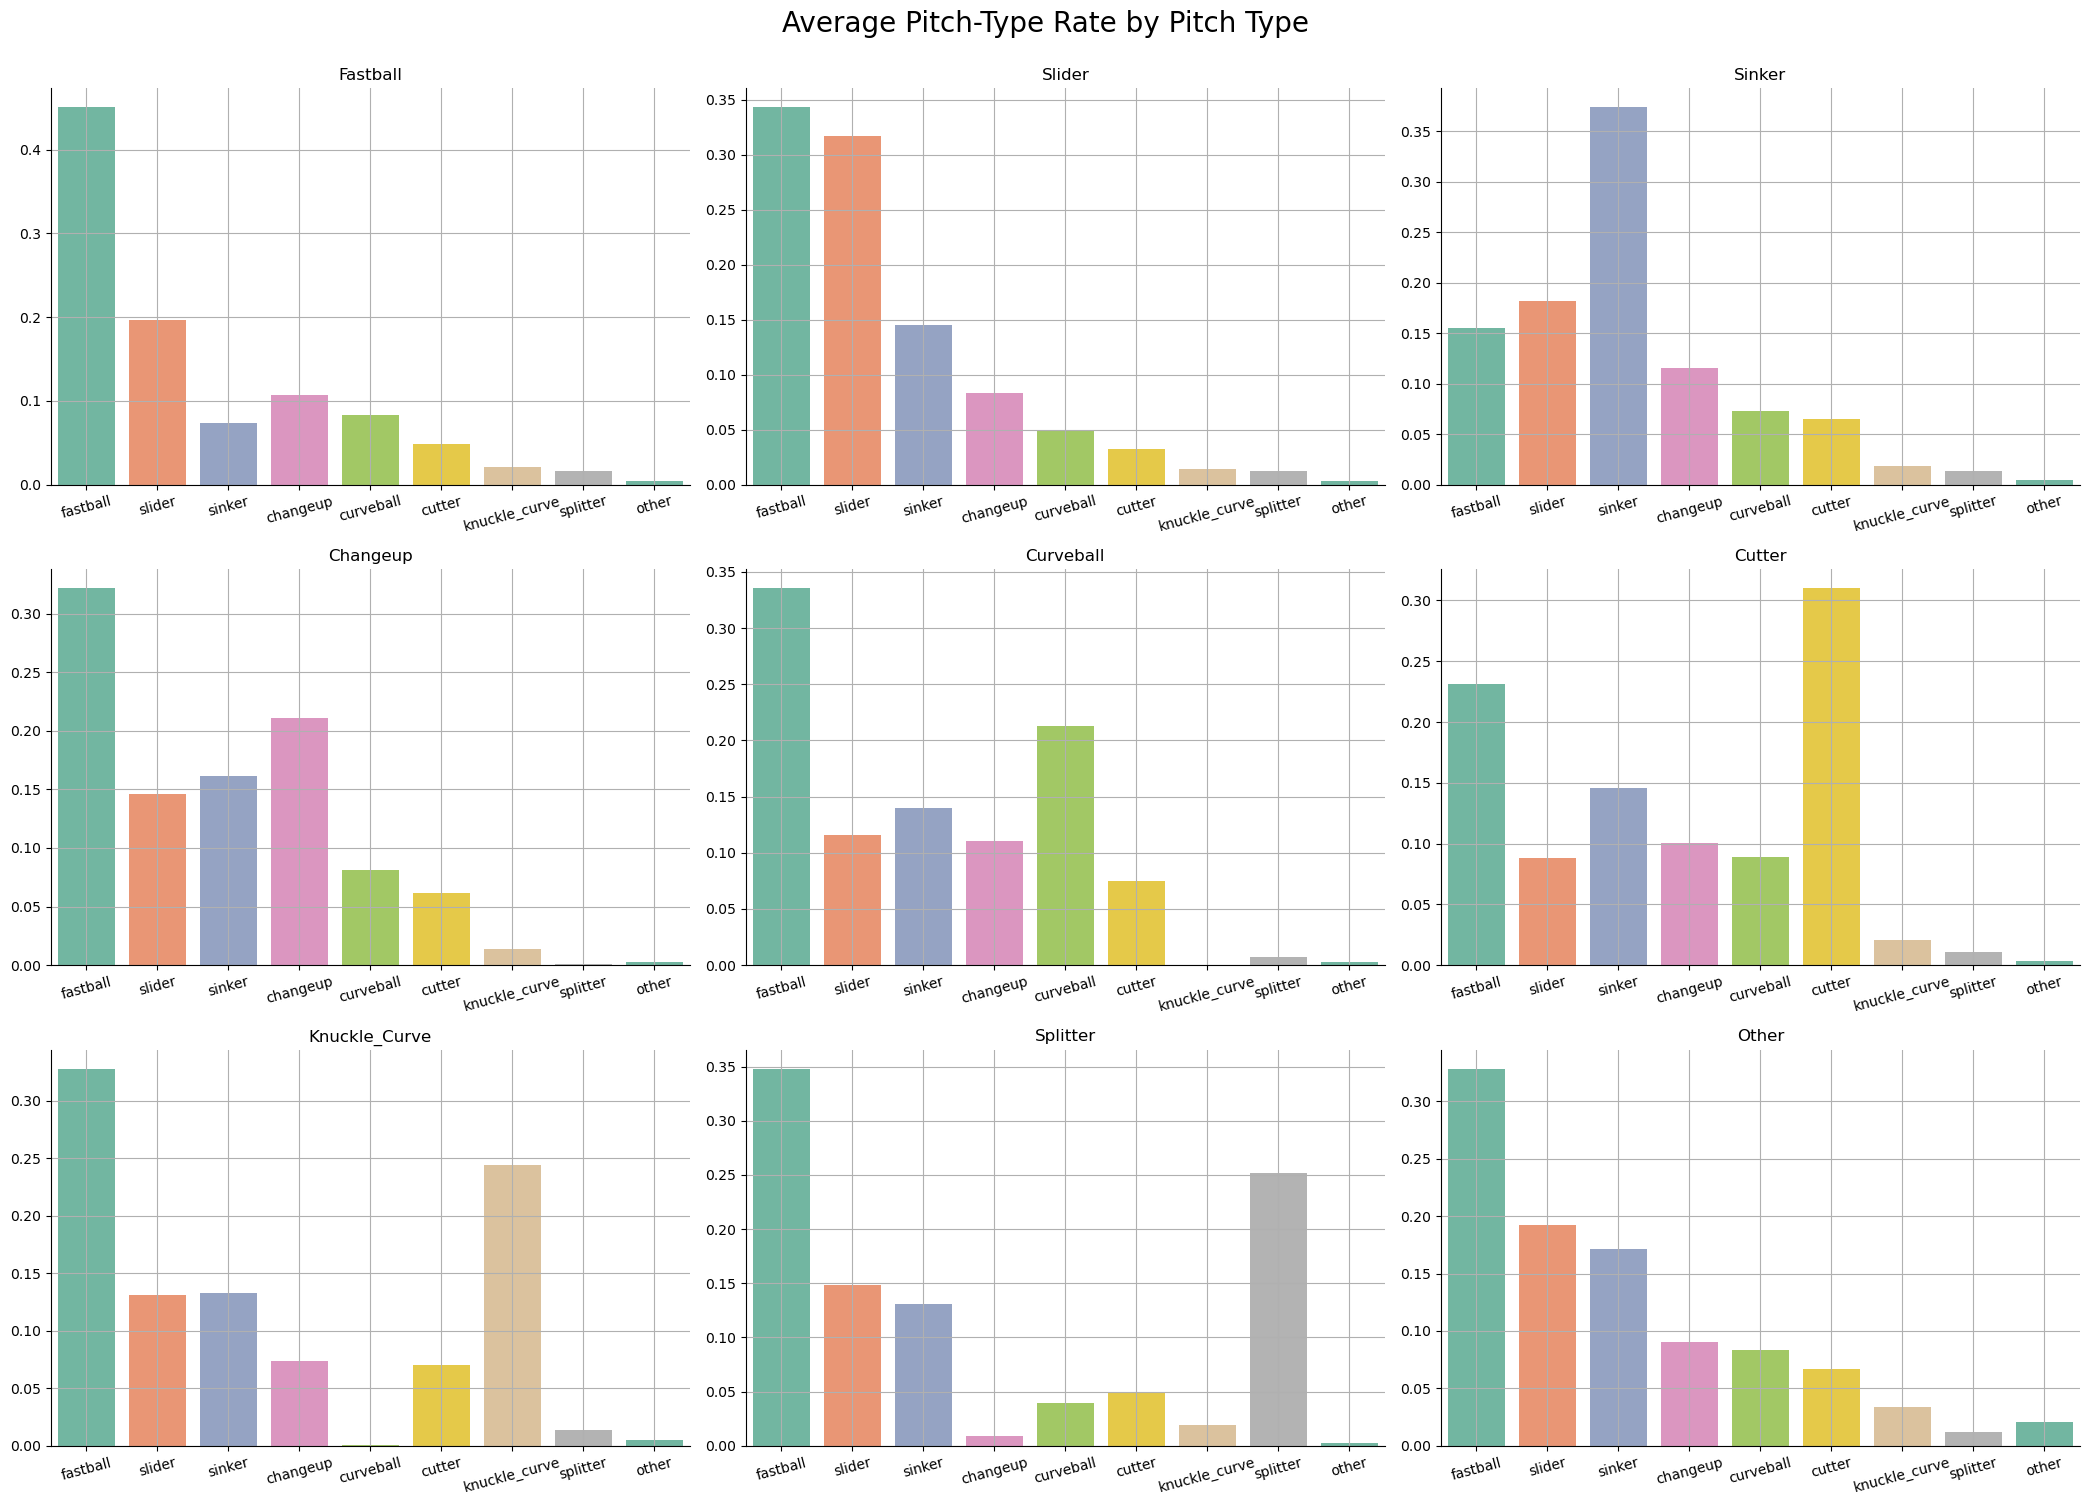

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    pitch_type = mean_rate_by_type.index[i]
    mean_rates = mean_rate_by_type.iloc[i]
    sns.barplot(x=mean_rates.index, y=mean_rates.values, ax=ax, palette='Set2')
    ax.set(title=pitch_type.title())
    ax.set_xticklabels([x.get_text().replace("_rate", "") for x in ax.get_xticklabels()], rotation=15)
    ax.grid()
    
fig.suptitle("Average Pitch-Type Rate by Pitch Type", fontsize=20, y=1)
plt.tight_layout()
sns.despine()
